In [491]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Paper/data reference: https://academic.oup.com/sleep/article/42/12/zsz180/5549536
# Physio Net data link: https://physionet.org/content/sleep-accel/1.0.0/
# Raw data preprocessing to create features done using: https://github.com/ojwalch/sleep_classifiers

In [492]:
# Code that goes through the 5 individual features for each subject and collects all the data to create one global dataframe
# that is subject agnostic. Each row of the training data simply contains the four features (heart rate, cosine, count, time)
# and then the sleep label associated with those features.

# The features are defined in the paper reference above under the "Methods" section

# Sleep stages: 0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5

def create_df(files):
    df_as_lst = []
    for file in files:
        with open(file, 'r') as f:
            tmp_lst = f.read().split('\n')
            df_as_lst.append(tmp_lst[:-1])
            
    d = {
        'heart_rate': df_as_lst[0],
        'cosine': df_as_lst[1],
        'count': df_as_lst[2],
        'time': df_as_lst[3],
        'label': df_as_lst[4]
    }
    
    df = pd.DataFrame(d).astype("float")

    return df

def generate_train_data():
    subjects = []
    dfs = []
    
    files = os.listdir("labels")
    
    for file in files:
        tmp = file.split("_")[0]
        subjects.append(tmp)
        
    for subject in subjects:
        parent = "sleep_classifiers-main/outputs/features/"
        
        hr_file = os.path.join(parent, subject + "_hr_feature.out")
        cosine_file = os.path.join(parent, subject + "_cosine_feature.out")
        count_file = os.path.join(parent, subject + "_count_feature.out")
        time_file = os.path.join(parent, subject + "_time_feature.out")
        label_file = os.path.join(parent, subject + "_psg_labels.out")
        
        lst = [hr_file, cosine_file, count_file, time_file, label_file]
        df = create_df(lst)
        dfs.append(df)
        #break
        
    final_df = pd.concat(dfs)
    
    return final_df
        

In [493]:
df = generate_train_data()

In [494]:
df.describe()

,heart_rate,cosine,count,time,label
count,25481.000000,25481.000000,25481.000000,25481.000000,25481.000000
mean,0.362630,-0.783055,1.776181,3.691549,2.567325
std,0.325169,0.210857,6.988129,2.267289,1.490956
min,0.014848,-1.000000,0.000000,0.000000,0.000000
25%,0.153271,-0.961262,0.000000,1.733333,2.000000
50%,0.279429,-0.852640,0.000000,3.533333,2.000000
75%,0.464529,-0.656059,0.329513,5.591667,3.000000
max,3.543115,-0.258819,158.035690,8.150000,5.000000


In [495]:
df.head()

,heart_rate,cosine,count,time,label
0,0.336561,-0.258819,0.000000,0.000000,0.0
1,0.322855,-0.260926,0.000000,0.008333,0.0
2,0.310544,-0.263031,0.002368,0.016667,0.0
3,0.299575,-0.265135,0.017676,0.025000,0.0
4,0.289984,-0.267238,0.050763,0.033333,0.0


In [496]:
# Labels distribution
df['label'].value_counts()

label
2.0    12483
5.0     5540
3.0     3189
0.0     2152
1.0     1761
4.0      356
Name: count, dtype: int64

In [497]:
# First task predict REM vs Non-REM sleep

def rem(value):
    if value < 5:
        return 0
    else:
        return 1
    
df['rem_label'] = df['label'].apply(rem)

In [498]:
df.sample(10)

,heart_rate,cosine,count,time,label,rem_label
198,0.160068,-0.639439,0.000046,1.650000,3.0,0
177,0.507319,-0.603556,0.000184,1.475000,2.0,0
320,0.188933,-0.819152,0.000000,2.666667,2.0,0
812,0.112152,-0.893959,1.363436,6.775000,5.0,1
370,0.086407,-0.876727,0.001057,3.083333,2.0,0
357,0.309409,-0.863836,0.000000,2.983333,2.0,0
454,0.178394,-0.949699,0.000000,3.783333,5.0,1
943,0.112838,-0.729864,0.000000,7.875000,2.0,0
180,0.292040,-0.608761,0.362032,1.500000,1.0,0
566,0.295348,-0.997250,0.451707,4.716667,5.0,1


In [499]:
df[df['rem_label'] == 0].describe()

,heart_rate,cosine,count,time,label,rem_label
count,19941.000000,19941.000000,19941.000000,19941.000000,19941.000000,19941.0
mean,0.341847,-0.757753,2.033805,3.378589,1.891480,0.0
std,0.344131,0.223389,7.773912,2.250000,0.859987,0.0
min,0.014848,-1.000000,0.000000,0.000000,0.000000,0.0
25%,0.134173,-0.957571,0.000000,1.408333,2.000000,0.0
50%,0.240255,-0.825360,0.000000,3.108333,2.000000,0.0
75%,0.423161,-0.589549,0.348166,5.216667,2.000000,0.0
max,3.543115,-0.258819,158.035690,8.125000,4.000000,0.0


In [500]:
df[df['rem_label'] == 1].describe()

,heart_rate,cosine,count,time,label,rem_label
count,5540.000000,5540.000000,5540.000000,5540.000000,5540.0,5540.0
mean,0.437436,-0.874132,0.848872,4.818037,5.0,1.0
std,0.230033,0.119487,2.446515,1.949582,0.0,0.0
min,0.054748,-1.000000,0.000000,0.433333,5.0,1.0
25%,0.275170,-0.968148,0.000000,3.258333,5.0,1.0
50%,0.391204,-0.912656,0.000003,4.812500,5.0,1.0
75%,0.559342,-0.806445,0.284444,6.458333,5.0,1.0
max,2.136630,-0.366501,28.291937,8.150000,5.0,1.0


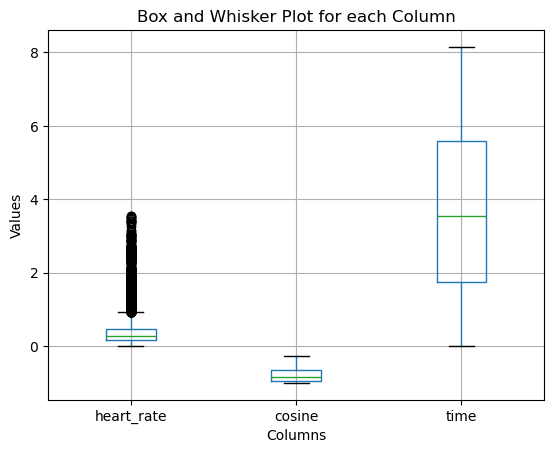

In [501]:
# Generating box and whisker plots for each column
df[['heart_rate', 'cosine', 'time']].boxplot()

# Display the plot
plt.title('Box and Whisker Plot for each Column')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

# Clearly have some interesting heart_rate values. The heart rate values were measured in bpm and
# then interpolated to have a value for every 1 second. I'll leave it for now but nearly 4 beats
# per second seems like an error

In [502]:
# Preparing dataset for training
labels = df.iloc[:,-1] # ignore all except rem label
data = df.iloc[:,:-2] # ignore label and rem_label

In [503]:
# No missing data
missing = data.isnull().sum()
missing

heart_rate    0
cosine        0
count         0
time          0
dtype: int64

In [504]:
# REM vs Non-REM label counts
labels.value_counts()

rem_label
0    19941
1     5540
Name: count, dtype: int64

In [505]:
# Quick random forest classifier for baseline values

# Load the dataset
X = data.values
y = labels.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced_subsample")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4007
           1       0.72      0.58      0.64      1090

    accuracy                           0.86      5097
   macro avg       0.81      0.76      0.78      5097
weighted avg       0.85      0.86      0.86      5097



In [506]:
# High accuracy, but imbalanced dataset so precision and recall tell a different story
# Moving on to a simple neural net

class Net(torch.nn.Module):
    def __init__(self, inputs, n_hidden1, n_hidden2):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(inputs, n_hidden1, bias=False)
        self.bn1 = torch.nn.BatchNorm1d(n_hidden1)
        self.relu1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(n_hidden1, n_hidden2, bias=False)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden2)
        self.relu2 = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(n_hidden2, 1, bias=True)
        
        # Apply Kaiming initialization to the linear layers with ReLU activation
        torch.nn.init.kaiming_normal_(self.l1.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.l2.weight, nonlinearity='relu')
        torch.nn.init.xavier_normal_(self.l3.weight, gain=1.0)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.l3(x)
        return x
    

In [540]:
# Pre-training initializations
torch.manual_seed(485785)
inputs = 4
n_hidden1 = 128
n_hidden2 = 64

model = Net(inputs, n_hidden1, n_hidden2)

######################## Tracking and computing training diagnostics ##########################
last_relu_outputs = [None] * sum(1 for layer in model.modules() if isinstance(layer, torch.nn.modules.activation.ReLU))
last_relu_grads = [None] * sum(1 for layer in model.modules() if isinstance(layer, torch.nn.modules.activation.ReLU))

hook_handles = []

def hook_fn_back(index):
    def fn_b(module, grad_in, grad_out):
        last_relu_grads[index] = grad_out[0].clone()
    return fn_b

layer_index = 0
for layer in model.modules():
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_full_backward_hook(hook_fn_back(layer_index)))
        layer_index += 1

def hook_fn(index):
    def fn(module, inputs, outputs):
        last_relu_outputs[index] = outputs
    return fn

layer_index = 0
for layer in model.modules():
    if isinstance(layer, torch.nn.modules.activation.ReLU):
        hook_handles.append(layer.register_forward_hook(hook_fn(layer_index)))
        layer_index += 1

def compute_ratio(parameter, lr):
    gradient_std = parameter.grad.std()
    data_std = parameter.data.std()  # Calculate data standard deviation for the same layer
    ratio = (lr * gradient_std / data_std).log10().item()
    return ratio

#############################################################################################

parameters = list(model.parameters())

# Total number of parameters
print("Parameters:",sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

torch_data = torch.tensor(data.values, dtype=torch.float32)
mean = torch.mean(torch_data, dim=0)
std = torch.std(torch_data, dim=0)
torch_data_norm = (torch_data - mean) / std

torch_labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(torch_data_norm, torch_labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 512
epochs = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

opt = torch.optim.Adam(model.parameters(), lr=0.03)

lossi = []
ud = []
accuracies = []
# 0.1 200 epochs

model.train()
for i in (t := trange(epochs)):
    for inputs, targets in train_loader:
        
        # forward pass
        outputs = model(inputs)
        #loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='mean', pos_weight=torch.tensor(3).float())
        loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='mean')

        # backward pass
        opt.zero_grad()
        loss.backward()
        
        # update step
        opt.step()
        
        # diagnostics
        with torch.no_grad():
            ud.append([compute_ratio(p, opt.param_groups[0]['lr']) for p in model.parameters()])
        
    lossi.append(loss.item())
    
    with torch.no_grad():
        targs = targets.detach().numpy()
        preds = F.sigmoid(outputs).detach().numpy()
        acc = accuracy_score(targs, (preds > 0.5).astype(int))
        accuracies.append(acc)
    
    # For tqdm
    t.set_description(f"Loss: {loss:.2f} Accuracy: {acc:.2f}")

print("Average Loss:", sum(lossi) / len(lossi))
print("Average Acc:", sum(accuracies) / len(accuracies))

Parameters: 9153


Loss: 0.41 Accuracy: 0.81: 100%|█████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.19it/s]

Average Loss: 0.39416255936026573
Average Acc: 0.8050841346153844


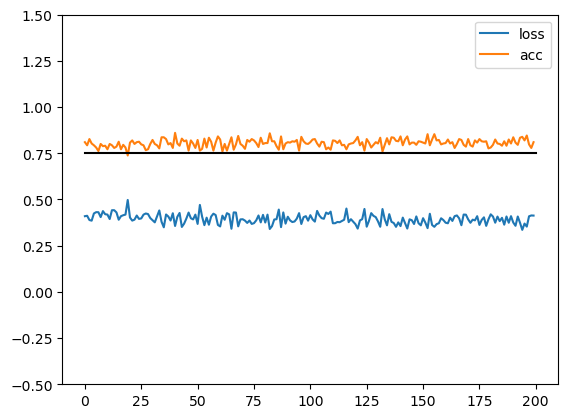

In [541]:
# Training loss 
# seems to hit a ceiling very quickly
plt.ylim(-0.5, 1.5)
plt.plot(torch.tensor(lossi).view(-1,1).mean(1), label="loss")
plt.plot(torch.tensor(accuracies).view(-1,1).mean(1), label="acc")
plt.plot([0, len(lossi)], [0.75, 0.75], 'k')
plt.legend()
plt.show()

layer 0 ( RelU 0): mean +0.47, std 1.15, saturated: 71.74%
layer 1 ( RelU 1): mean +0.14, std 0.59, saturated: 88.88%


Text(0.5, 1.0, 'activation distribution')

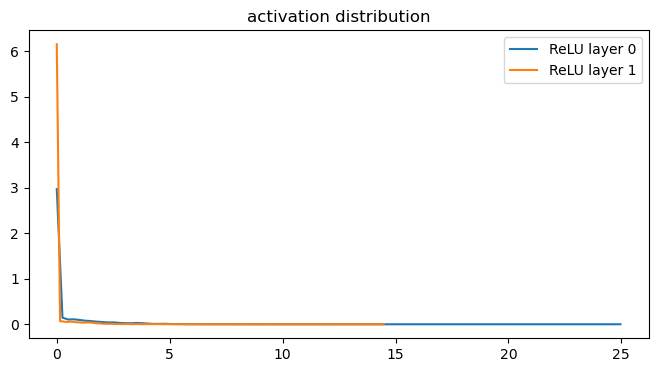

In [548]:
# Visualize Activation Distribution
plt.figure(figsize=(8, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_outputs):
    t = output
    print('layer %d (%7s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, "RelU " + str(i), t.mean(), t.std(), (t == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends)
plt.title('activation distribution')

layer 0 (    RelU 0): mean +0.000000, std 1.722031e-04
layer 1 (    RelU 1): mean +0.000006, std 7.572633e-04


Text(0.5, 1.0, 'gradient distribution')

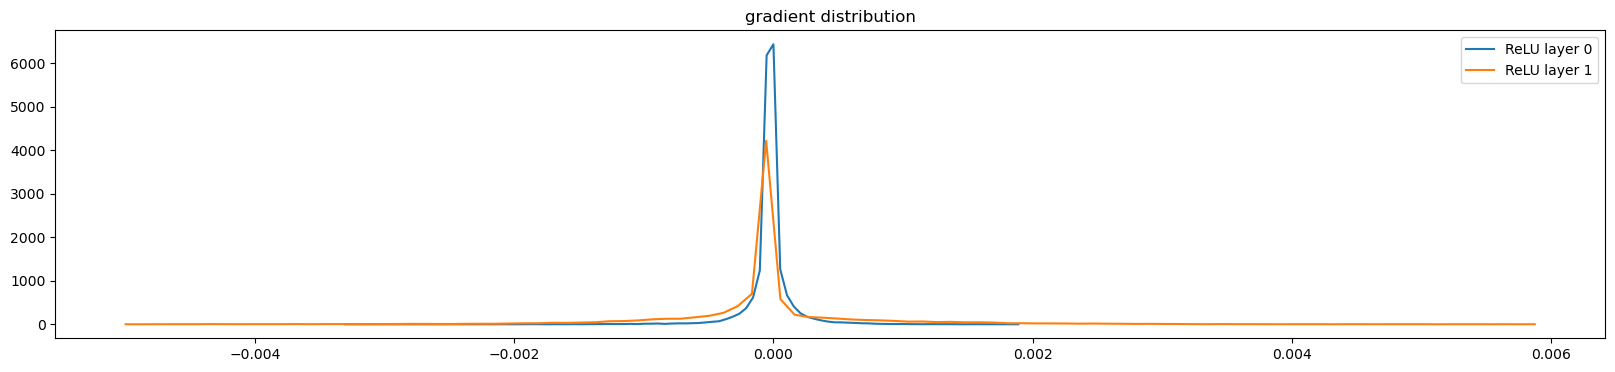

In [543]:
# Visualize Gradient Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, output in enumerate(last_relu_grads):
    t = output
    print('layer %d (%10s): mean %+f, std %e' % (i, "RelU " + str(i), t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    #hy /= hy.sum() # normalize, not sure about adding this yet. For consistency I'm leaving it out, may add later.
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'ReLU layer {i}')
plt.legend(legends);
plt.title('gradient distribution')

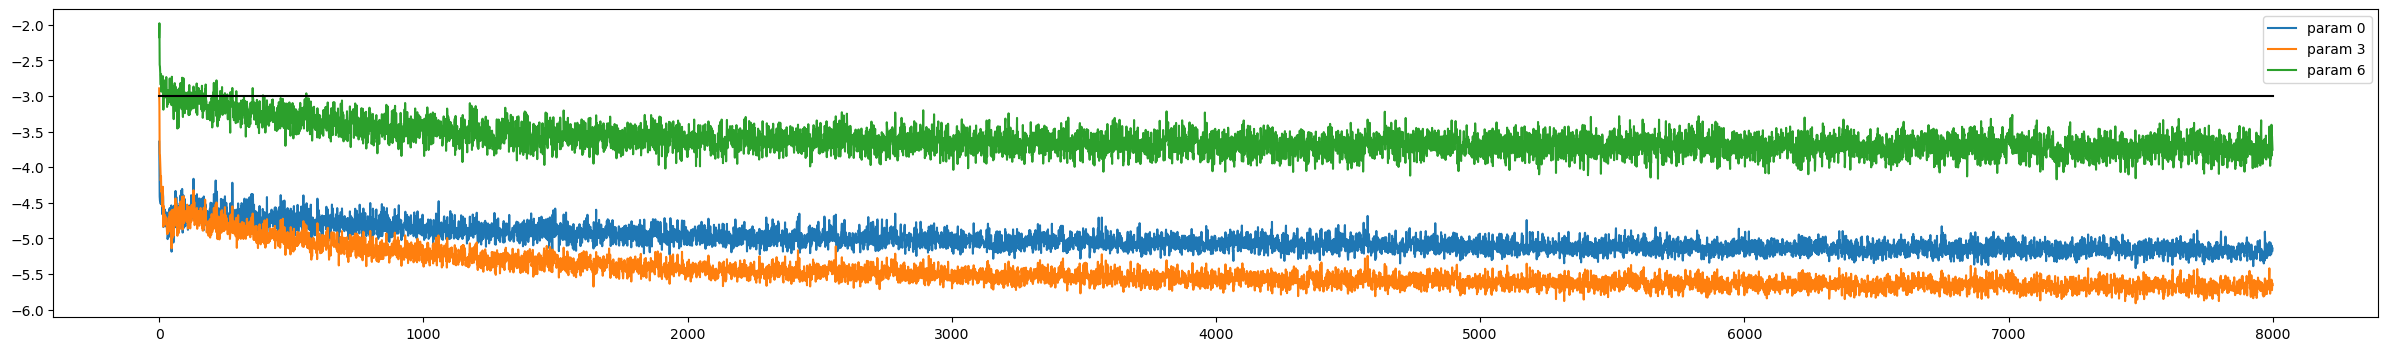

In [544]:
# Visualize Update-to-Data Ratio
plt.figure(figsize=(30, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [545]:
# Test set statistics
test_losses = []
test_accuracies = []
test_predictions = []
test_targets = []

with torch.no_grad():
    model.eval()
    
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='mean', pos_weight=torch.tensor(3).float())
        
        t_targs = targets.detach().numpy()
        t_preds = F.sigmoid(outputs).detach().numpy()
        test_targets.append(t_targs)
        test_predictions.append(t_preds)
        
        acc = accuracy_score(targs, (preds > 0.5).astype(int))
        test_losses.append(loss.item())
        test_accuracies.append(acc)
        
    test_predictions = np.vstack(test_predictions)
    test_targets = np.vstack(test_targets)
    
    accuracy = accuracy_score(test_targets, (test_predictions > 0.5).astype(int))
    prec_1 = precision_score(test_targets, (test_predictions > 0.5).astype(int), pos_label=1)
    rec_1 = recall_score(test_targets, (test_predictions > 0.5).astype(int), pos_label=1)
    prec_2 = precision_score(test_targets, (test_predictions > 0.5).astype(int), pos_label=0)
    rec_2 = recall_score(test_targets, (test_predictions > 0.5).astype(int), pos_label=0)
    
    print("Accuracy:", accuracy)
    print("REM Precision:", prec_1)
    print("REM Recall:", rec_1)
    print("Non-REM Precision:", prec_2)
    print("Non-REM Recall:", rec_2)
    
    cm = confusion_matrix(test_targets, (test_predictions > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(test_targets, (test_predictions > 0.5).astype(int)).ravel()
    print("True Negative:{}, False Positive:{}, False Negative:{}, True Positive:{}".format(tn, fp, fn, tp))

Accuracy: 0.8116539140670983
REM Precision: 0.6198224852071006
REM Recall: 0.37344028520499106
Non-REM Precision: 0.8409862022166931
Non-REM Recall: 0.9353459119496855
True Negative:3718, False Positive:257, False Negative:703, True Positive:419


In [546]:
# Test set class counts
unique_elements, counts = np.unique(test_targets, return_counts=True)

# Print unique elements and their counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0.0: 3975
1.0: 1122


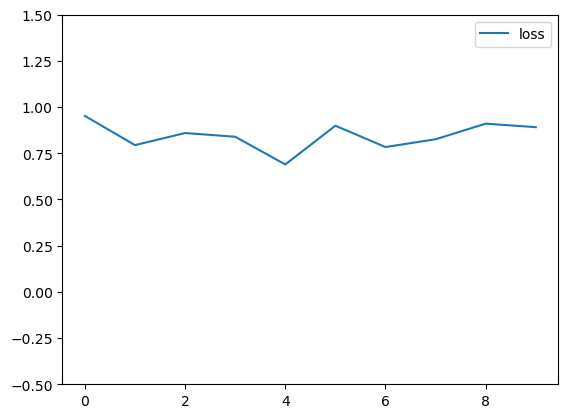

In [547]:
# Test set loss
plt.ylim(-0.5, 1.5)
plt.plot(torch.tensor(test_losses).view(-1,1).mean(1), label="loss")
#plt.plot([0, len(lossi)], [0.75, 0.75], 'k')
plt.legend()
plt.show()

### Results

- Accuracy: 0.8116539140670983
- REM Precision: 0.6198224852071006
- REM Recall: 0.37344028520499106
- Non-REM Precision: 0.8409862022166931
- Non-REM Recall: 0.9353459119496855
- True Negative:3718, False Positive:257, False Negative:703, True Positive:419

This was just simple approach to classifying REM vs. Non-REM sleep with both a random forest classifier and a fully connected neural network. If you compare these results to the random forest classifier above the neural net is actually marginally worse. This is mostly in part due to the lack of data the network is training on as it is both a small dataset and it only has four input features. If it had more data of varying information it would ultimately surpass the random forest. I tried a few different variations of the NN, but they all ultimately achieved around the same results. I was suprised the model performed this well to be honest, because to my untrained eye many of the statistics of REM vs. Non-REM sleep seemed very similar in this dataset. More features and more data would be a good step towards a more effective model on this task, although I suppose you can say that for just about any machine learning problem.